In [0]:
!wget https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/DL0321EN/data/images/concrete_crack_images_for_classification.zip -P /resources/data

--2020-03-31 16:02:15--  https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/DL0321EN/data/images/concrete_crack_images_for_classification.zip
Resolving s3-api.us-geo.objectstorage.softlayer.net (s3-api.us-geo.objectstorage.softlayer.net)... 67.228.254.196
Connecting to s3-api.us-geo.objectstorage.softlayer.net (s3-api.us-geo.objectstorage.softlayer.net)|67.228.254.196|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 245259777 (234M) [application/zip]
Saving to: ‘/resources/data/concrete_crack_images_for_classification.zip’

concrete_crack_imag 100%[===================>] 233.90M  36.7MB/s    in 7.1s    

2020-03-31 16:02:22 (33.1 MB/s) - ‘/resources/data/concrete_crack_images_for_classification.zip’ saved [245259777/245259777]



In [0]:
!unzip -q  /resources/data/concrete_crack_images_for_classification.zip -d  /resources/data

In [0]:
from PIL import Image
import matplotlib.pyplot as plt
import os
import glob
import torch
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
import torch.nn as nn
from torch import optim 

In [0]:
class Dataset(Dataset):

    # Constructor
    def __init__(self,transform=None,train=True):
        directory="/resources/data"
        positive="Positive"
        negative="Negative"

        positive_file_path=os.path.join(directory,positive)
        negative_file_path=os.path.join(directory,negative)
        positive_files=[os.path.join(positive_file_path,file) for file in  os.listdir(positive_file_path) if file.endswith(".jpg")]
        positive_files.sort()
        negative_files=[os.path.join(negative_file_path,file) for file in  os.listdir(negative_file_path) if file.endswith(".jpg")]
        negative_files.sort()
        number_of_samples=len(positive_files)+len(negative_files)
        self.all_files=[None]*number_of_samples
        self.all_files[::2]=positive_files
        self.all_files[1::2]=negative_files 
        # The transform is goint to be used on image
        self.transform = transform
        #torch.LongTensor
        self.Y=torch.zeros([number_of_samples]).type(torch.LongTensor)
        self.Y[::2]=1
        self.Y[1::2]=0
        
        if train:
            self.all_files=self.all_files[0:30000]
            self.Y=self.Y[0:30000]
            self.len=len(self.all_files)
        else:
            self.all_files=self.all_files[30000:]
            self.Y=self.Y[30000:]
            self.len=len(self.all_files)    
       
    # Get the length
    def __len__(self):
        return self.len
    
    # Getter
    def __getitem__(self, idx):
        
        
        image=Image.open(self.all_files[idx])
        y=self.Y[idx]
           # If there is any transform method, apply it onto the image
        if self.transform:
            image = self.transform(image)

        return image, y

In [0]:
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]
# transforms.ToTensor()
#transforms.Normalize(mean, std)
#transforms.Compose([])

transform =transforms.Compose([ transforms.ToTensor(), transforms.Normalize(mean, std)])

In [0]:
dataset_train=Dataset(transform=transform,train=True)
dataset_val=Dataset(transform=transform,train=False)

In [0]:
dataset_train[0][0].shape

torch.Size([3, 227, 227])

In [0]:
size_of_image=3*227*227
size_of_image


154587

In [0]:
# Create a custom module

class SoftMax(nn.Module):
    
    # Constructor
    def __init__(self, input_size, output_size):
        super(SoftMax, self).__init__()
        self.linear = nn.Linear(input_size, output_size)
        
    # Prediction
    def forward(self, x):
        yhat = self.linear(x)
        return yhat

In [0]:
input_size = 227*227*3
output_size = 20 #tbd



In [0]:
model=SoftMax(input_size,output_size)
print(model)

SoftMax(
  (linear): Linear(in_features=154587, out_features=20, bias=True)
)


In [0]:
# Print the parameters

print('W: ',list(model.parameters())[0].size())
print('b: ',list(model.parameters())[1].size())

W:  torch.Size([20, 154587])
b:  torch.Size([20])


In [0]:
optimizer = torch.optim.SGD(model.parameters(), lr = 0.1, momentum=0.1)

In [0]:
criterion = nn.CrossEntropyLoss()

In [0]:
trainloader = DataLoader(dataset = SoftMax, batch_size = 1000)
val_data = Data(train = False)

In [0]:
train_loader = torch.utils.data.DataLoader(dataset=dataset_train, batch_size=100)
validation_loader = torch.utils.data.DataLoader(dataset=dataset_val, batch_size=500)

In [0]:
# Train the model

n_epochs = 5
loss_list = []
accuracy_list = []
N_test = len(dataset_val)

def train_model(n_epochs):
    for epoch in range(n_epochs):
        for x, y in train_loader:
            optimizer.zero_grad()
            z = model(x.view(-1, input_size))
            loss = criterion(z, y)
            loss.backward()
            optimizer.step()
            
        correct = 0
        # perform a prediction on the validationdata  
        for x_test, y_test in validation_loader:
            z = model(x_test.view(-1, input_size))
            _, yhat = torch.max(z.data, 1)
            correct += (yhat == y_test).sum().item()
        accuracy = correct / N_test
        loss_list.append(loss.data)
        accuracy_list.append(accuracy)

train_model(n_epochs)

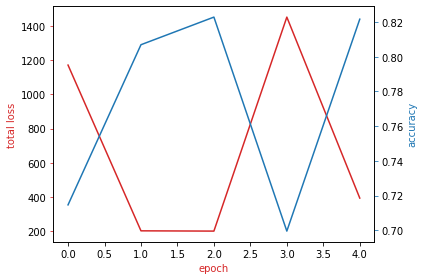

In [0]:
# Plot the loss and accuracy

fig, ax1 = plt.subplots()
color = 'tab:red'
ax1.plot(loss_list,color=color)
ax1.set_xlabel('epoch',color=color)
ax1.set_ylabel('total loss',color=color)
ax1.tick_params(axis='y', color=color)
    
ax2 = ax1.twinx()  
color = 'tab:blue'
ax2.set_ylabel('accuracy', color=color)  
ax2.plot( accuracy_list, color=color)
ax2.tick_params(axis='y', color=color)
fig.tight_layout()

fig.savefig('accuracy.png', dpi=300)

In [0]:
accuracy_list

[0.7147, 0.8069, 0.8228, 0.6996, 0.8216]